---
title: "Shaders with WebGPU"
execute: 
  enabled: true
---

In [252]:
#| code-fold: true
%matplotlib inline

import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, Image, HTML

from wgpu_shadertoy import Shadertoy

IS_QUARTO = True if os.getenv("IS_QUARTO", "0") == "1" else False
if IS_QUARTO:
    print("Running in Quarto, rendering as Gifs")

def _mk_gif(shader, end, n, interval, dpi=75):
    frames = [np.array(shader.snapshot(i)) for i in np.linspace(0, end, num=n)]
    resolution = tuple(dim/dpi for dim in frames[0].shape[:2])
    fig = plt.figure(figsize=resolution)
    
    def animate(i):
        plt.clf()
        plt.imshow(frames[i])
        plt.axis('off')
    
    anim = FuncAnimation(
        fig, 
        animate, 
        frames=len(frames),
        interval=interval,  # ms between frames
        repeat=True
    )
    html = anim.to_jshtml(default_mode='loop')
    plt.close()

    # Hide controls
    html = html.replace(
        '<div class="anim-controls">',
        '<div class="anim-controls" style="display: none;">'
    )
    
    # Autoplay gif
    autoplay_script = """
    <script>
        setTimeout(function() {
            var animations = document.getElementsByClassName('animation');
            for (var i = 0; i < animations.length; i++) {
                var buttons = animations[i].getElementsByTagName('button');
                for (var j = 0; j < buttons.length; j++) {
                    if (buttons[j].title === 'Play') {
                        buttons[j].click();
                        break;
                    }
                }
            }
        }, 1000);
    </script>
    """
    
    display(HTML(html + autoplay_script))

def render(cfp, resolution=(250, 250), stacktrace=False, gif=IS_QUARTO, end_time=1, n=1, interval=50):
    code = open(cfp).read() if os.path.exists(cfp) else cfp
    try:
        shader = Shadertoy(code, resolution, offscreen=gif)
        if gif: _mk_gif(shader, end_time, n, interval)
        else: shader.show()
    except Exception as e:
        if stacktrace:
            raise e
        else:
            print("=== ERROR ===\n")
            print(e)

So I don't have to keep repeating myself, I'll append previously defined functions to funcs:

In [228]:
funcs_0 = ""

## 1. Simple Square

Let's show a color. There seems to be some wonkiness when rendering with Jupyter (I think using Pillow?) it seems to render BGRA rather than RGBA. Tested this same code is rendered as BGRA when running as python using `glfw` renderer.

Anywho we've got a `b2r` function now.

In [254]:
funcs_1 = funcs_0 + """
fn b2r(bgra: vec4<f32>) -> vec4<f32>
{
    return bgra.bgra;
}
"""

render(funcs_1 + """
fn shader_main(coord: vec2<f32>) -> vec4<f32>
{
    return b2r(vec4<f32>(1.0, 0.0, 0.0, 1.0));
    
}
""")

## 2. RG Color based on pixel position

Here we can use the pixel coordinates to give us an intensity for red and green. Since the returned values should have range 0-1, we need to normalize the pixel coordinate first using `i_resolution`.

RFBOutputContext()

JupyterWgpuCanvas(css_height='250.0px', css_width='250.0px')
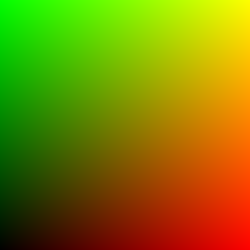

In [234]:
render(funcs_1 + """
fn shader_main( coord: vec2<f32>  ) -> vec4<f32>
{
    // normalized pixel coordinate (0-1)
    let uv: vec2<f32> = coord / i_resolution.xy;
    // x = red intensity (left to right)
    // y = green intensity (bottom to top)
    let out = vec4<f32>(uv, 0.0, 1.0);
    return b2r(out);
}
""")

## 3. Modulate with time

First animated render! This modulates the intensity using `abs(cos(i_time)` (absolute because -1 intensity is clamped to 0, so we'd rather it just be positive.

`i_time` is just the current time of the frame, we could also use `i_frame` for this.

RFBOutputContext()

JupyterWgpuCanvas(css_height='250.0px', css_width='250.0px')
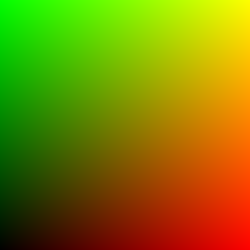

In [235]:
render(funcs_1 + """
fn shader_main( coord: vec2<f32>  ) -> vec4<f32>
{
    // normalized pixel coordinate (0-1)
    let uv: vec2<f32> = coord / i_resolution.xy;
    // multiplier using `i_time`, this will modulate between 0 and 1.
    let intensity = abs(cos(i_time)); // 0-1
    // x = red intensity (left to right)
    // y = green intensity (bottom to top)
    let out = vec4<f32>(uv * intensity, 0.0, 1.0);
    return b2r(out);
}
""", end_time=np.pi, n=100)

## 4. Square

Ok so how do we draw shapes? Since we draw each pixel individually, we need a function that given a single coordinate, "indicates" whether it's in the shape or not. Here `square_indicator` checks if we're inside the x and y bound, returning 1 if true. Easy!

RFBOutputContext()

JupyterWgpuCanvas(css_height='250.0px', css_width='250.0px')
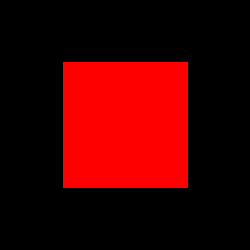

In [237]:
funcs_4 = funcs_1 + """
fn square_indicator(coord: vec2<f32>, bound_x: vec2<f32>, bound_y: vec2<f32>) -> f32
{
    if (
        coord.x >= bound_x.x && coord.x <= bound_x.y    // inside x
        && coord.y >= bound_y.x && coord.y <= bound_y.y // inside y
    ) {
        return 1.0;
    }
    return 0.0;
}
"""

render(funcs_4 + """
fn shader_main(coord: vec2<f32>) -> vec4<f32>
{
    let uv = coord / i_resolution.xy;
    let in_square: f32 = square_indicator(uv, vec2(0.25, 0.75), vec2(0.25, 0.75));
    if (in_square > 0.0) {
        return b2r(vec4(1.0, 0.0, 0.0, 1.0));
    }
    return b2r(vec4(0.0, 0.0, 0.0, 1.0));
    
}
""")

## 5. Simple Circle

Circles work roughly the same, but we need to do our first translation. If we want to use `a^2 + b^2 = c^2`, aka magnitude from the center of the circle, the center must be `(0, 0)`. However that's in the bottom left, so we shift all coords 0.5 to the left and down so that the render is now centered around `(0, 0)`.

RFBOutputContext()

JupyterWgpuCanvas(css_height='250.0px', css_width='250.0px')
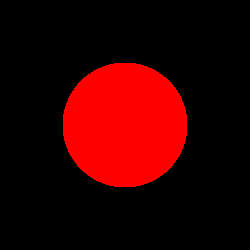

In [239]:
funcs_5 = funcs_4 + """
fn circle_indicator(coord: vec2<f32>, radius: f32) -> f32
{
    // length is the magnitude of the vector
    return f32(length(coord) <= radius);
}
"""

render(funcs_5 + """
fn shader_main(coord: vec2<f32>) -> vec4<f32>
{
    let uv = coord / i_resolution.xy;
    // our circle is centered around 0, which since we start in the bottom left is 0,0
    // so if we want it centered we need to translate the center to 0,0
    let uv_translate = uv - vec2(0.5, 0.5);
    let in_square: f32 = circle_indicator(uv_translate, 0.25);
    if (in_square > 0.0) {
        return b2r(vec4(1.0, 0.0, 0.0, 1.0));
    }
    return b2r(vec4(0.0, 0.0, 0.0, 1.0));
}
""")

## 6. Better Translate

We had an easy translate function in the previous function, but we're going to want to matrix combine our transformations in a bit so let's make a matmul version. This works with any coord.

RFBOutputContext()

JupyterWgpuCanvas(css_height='250.0px', css_width='250.0px')
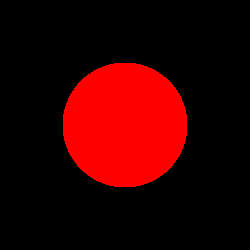

In [240]:
funcs_6 = funcs_5 + """
fn mk_translate(x: f32, y: f32) -> mat3x3<f32>
{
    // webgpu does column-major!
    return mat3x3<f32>(
        1.0, 0.0, 0.0,
        0.0, 1.0, 0.0,
        x,   y,   1.0,
    );
}
"""

render(funcs_6 + """
fn shader_main(coord: vec2<f32>) -> vec4<f32>
{
    let uv2 = coord / i_resolution.xy;
    let uv3 = vec3<f32>(uv2, 1.0);
    // our circle is centered around 0, which since we start in the bottom left is 0,0
    // so if we want it centered we need to translate the center to 0,0
    let uv_translate = mk_translate(-0.5, -0.5) * uv3;
    let in_circle: f32 = circle_indicator(uv_translate.xy, 0.25);
    if (in_circle > 0.0) {
        return b2r(vec4(1.0, 0.0, 0.0, 1.0));
    }
    return b2r(vec4(0.0, 0.0, 0.0, 1.0));
}
""")

## Making a Clock

Cool! So we can do some basic shapes and did a transformation. I like working towards something, so lets try to create a clock. This has a few nice things

1. Rotation matrix
2. Multiple shapes
3. Time component

### 7. Drawing the Hand

To draw a rotating hand, we need to draw a rectangle and apply a rotation based on the current time.

The rotation matrix operates from coordinates `(0, 0)`, so if we want to rotate around the center we're going to have to translate again.

RFBOutputContext()

JupyterWgpuCanvas(css_height='250.0px', css_width='250.0px')
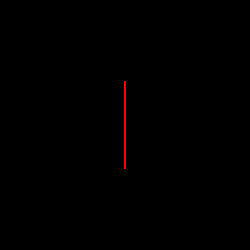

In [245]:
funcs_7 = funcs_6 + """
fn mk_rotate(rads: f32) -> mat3x3<f32>
{
    let cos_t = cos(rads);
    let sin_t = sin(rads);
    // column-major!
    return mat3x3<f32>(
        cos_t,  sin_t, 0.0,
        -sin_t, cos_t, 0.0,
        0.0,    0.0,   1.0,
    );
}

/**
* Alternative square indicator impl, we assume center is at origin.
* This means we only have to pass the width and height of the rectangle we want.
*/
fn square_indicator_origin(coord: vec2<f32>, width: f32, height: f32) -> f32
{
    if (coord.x >= -0.5 * height && coord.x <= 0.5 * height  // inside x
        && coord.y >= -0.5 * width && coord.y <= 0.5 * width // inside y
    ) {
        return 1.0;
    }
    return 0.0;
}
"""

render(funcs_7 + """
fn shader_main(coord: vec2<f32>) -> vec4<f32>
{
    let uv2 = coord / i_resolution.xy;
    let uv3 = vec3<f32>(uv2, 1.0);
    
    let xfm = mk_rotate(i_time) *       // 2. Rotate
              mk_translate(-0.5, -0.5); // 1. Move to center
    let look = xfm * uv3;
    
    let in_hand = square_indicator_origin(look.xy, 0.35, 0.01); // length, width of hand
    return b2r(vec4(in_hand, 0.0, 0.0, 1.0));
}
""", end_time=np.pi * 2, n=200)

So here we are moving to the center, and rotating. But there's a problem... we want to rotate from the edge of the hand, not the center.

This requires three transformations:

1. Moving rotation point to the center
2. Applying rotation
3. Shifting the rotation to the end of the hand
    - This kind of acts as an "orbit" around the rotation point

RFBOutputContext()

JupyterWgpuCanvas(css_height='250.0px', css_width='250.0px')
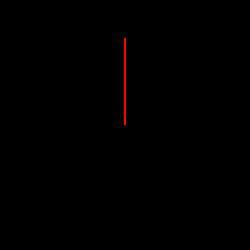

In [251]:
render(funcs_7 + """
fn shader_main(coord: vec2<f32>) -> vec4<f32>
{
    let uv2 = coord / i_resolution.xy;
    let uv3 = vec3<f32>(uv2, 1.0);

    let hand_length = 0.35;
    
    let xfm = mk_translate(0.0, -hand_length / 2.) * // 3. Shift rotation to end of hand
              mk_rotate(i_time) *                    // 2. Rotate
              mk_translate(-0.5, -0.5);              // 1. Move to center
    let look = xfm * uv3;
    
    let in_hand = square_indicator_origin(look.xy, hand_length, 0.01); // length, width of hand
    return b2r(vec4(in_hand, 0.0, 0.0, 1.0));
}
""", end_time=np.pi * 2, n=200)

Much better!

### 8. Full Clock

This kind of just uses everything we've done so far, to make 3 different hands rotate.

The only things that we haven't seen before is:

- `i_time * 2 * PI` so that each unit of `i_time` is one rotation of the second hand
    - Then `/ 60` for 60 units of `i_time` for one rotation, so 1 minute.
    - Then `* SPEEDUP` because I don't want to wait.
- Since the face is white, `#FFFFFF` this would drown out our hand colors. So we selectively return based on whether we're
    1. In the hands
    2. In the notch
    3. In the face

And that's pretty much it!

RFBOutputContext()

JupyterWgpuCanvas(css_height='250.0px', css_width='250.0px')
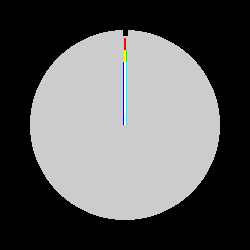

In [248]:
render(funcs_7 + """
const PI = 3.14159265359;
const SPEEDUP = 30.0;

const SECOND_LENGTH = 0.35;
const SECOND_WIDTH = 0.01;
const MINUTE_LENGTH = 0.3;
const MINUTE_WIDTH = 0.012;
const HOUR_LENGTH = 0.25;
const HOUR_WIDTH = 0.018;

const NOTCH_LENGTH = 0.05;
const NOTCH_WIDTH = 0.02;

const FACE_RADIUS = 0.38;
const FACE_GAMMA = 0.8;

fn _hand_xfm(angle: f32, length: f32) -> mat3x3<f32>
{
    return mk_translate(0.0, -length / 2.) * // 3. Shift rotation to end of hand
           mk_rotate(angle) *                // 2. Rotate
           mk_translate(-0.5, -0.5);         // 1. Move to center
}

fn shader_main(coord: vec2<f32>) -> vec4<f32>
{
    let uv2 = coord / i_resolution.xy;
    let uv3 = vec3<f32>(uv2, 1.0);

    /* Hands */
    let second_angle = SPEEDUP * i_time * 2.0 * PI / 60.0;
    let minute_angle = second_angle / 60.0;
    let hour_angle = minute_angle / 60.0;

    let second_look = _hand_xfm(second_angle, SECOND_LENGTH) * uv3;
    let minute_look = _hand_xfm(minute_angle, MINUTE_LENGTH) * uv3;
    let hour_look   = _hand_xfm(hour_angle, HOUR_LENGTH)     * uv3;

    let in_second = square_indicator_origin(second_look.xy, SECOND_LENGTH, SECOND_WIDTH);
    let in_minute = square_indicator_origin(minute_look.xy, MINUTE_LENGTH, MINUTE_WIDTH);
    let in_hour =   square_indicator_origin(hour_look.xy,   HOUR_LENGTH,   HOUR_WIDTH);
    let hand_color = vec4(in_second, in_minute, in_hour, 1.0);
    if (length(hand_color.xyz) > 0.0) {
        return b2r(hand_color);
    }

    /* Notch */
    let notch_look = mk_translate(-0.5, -0.5 - FACE_RADIUS) * uv3;
    let in_notch = square_indicator_origin(notch_look.xy, NOTCH_LENGTH, NOTCH_WIDTH);
    if (in_notch > 0.0) {
        return b2r(vec4(0.0, 0.0, 0.0, 1.0));
    }

    /* Face */
    let face_look = mk_translate(-0.5, -0.5) * uv3;
    let in_face = circle_indicator(face_look.xy, FACE_RADIUS);
    let circle_color = vec4(in_face * FACE_GAMMA, in_face * FACE_GAMMA, in_face * FACE_GAMMA, 1.0);

    return b2r(circle_color);
    
}
""", end_time=30, n=500, interval=60)


args are for gif rendering (ignored in normal render)

- render 15 mins -- `end_time (30) * pi * SPEEDUP (30) * 2 * pi`
- in a 30 second gif (500 frames * 60ms per frame)
- aka 30x speedup.